### Purpose: Create a dataloader 

###### Date:11/13/2019

In [1]:
# Import libraries
from __future__ import print_function, division
import os
from skimage import io, transform
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader, Dataset
# import torchvision
# from torchvision import transforms

print(torch.__version__)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

1.3.0


### Check the data catalog

In [2]:
data_root='/datadrive/UTC/'
place = 'Santa_Monica'
data_path=data_root+place+'/'

catalog_path = data_root+'data_catalog.csv'

data_catalog = pd.read_csv(catalog_path) 

data_catalog.head()

,raster_path,imagery_path,binary_path,place,tileID,suffix,img_size,res,pad,lat,...,img_src,lidar_src,band_means,band_stds,ndvi_mean,ndvi_std,ndvi_NaN,height_mean,height_std,height_NaN
0,/datadrive/UTC/Santa_Monica/combiTif/Santa_Mon...,/datadrive/UTC/Santa_Monica/NAIP/imagery/none/...,/datadrive/UTC/Santa_Monica/fullMasks/binary/S...,Santa_Monica,0,A,256,1,0,359712.0,...,naip1,USGS_LPC_CA_LosAngeles_2016_LAS_2018,"[18.891204833984375, 18.5040283203125, 17.6068...","[57.29494771343193, 56.12163180997879, 53.4039...",-0.094515,0.006674,59109,0.129057,0.209841,592
1,/datadrive/UTC/Santa_Monica/combiTif/Santa_Mon...,/datadrive/UTC/Santa_Monica/NAIP/imagery/none/...,/datadrive/UTC/Santa_Monica/fullMasks/binary/S...,Santa_Monica,1,A,256,1,0,359712.0,...,naip1,USGS_LPC_CA_LosAngeles_2016_LAS_2018,"[1.288421630859375, 1.2667694091796875, 1.2102...","[15.699684914668946, 15.430954788947341, 14.73...",-0.092167,0.028384,65095,0.347044,1.274629,6
2,/datadrive/UTC/Santa_Monica/combiTif/Santa_Mon...,/datadrive/UTC/Santa_Monica/NAIP/imagery/none/...,/datadrive/UTC/Santa_Monica/fullMasks/binary/S...,Santa_Monica,2,A,256,1,0,359968.0,...,naip1,USGS_LPC_CA_LosAngeles_2016_LAS_2018,"[13.987213134765625, 13.629104614257812, 13.28...","[48.43713477757454, 47.19827194378038, 46.0044...",-0.055390,0.009834,60489,-0.036909,0.300037,0
3,/datadrive/UTC/Santa_Monica/combiTif/Santa_Mon...,/datadrive/UTC/Santa_Monica/NAIP/imagery/none/...,/datadrive/UTC/Santa_Monica/fullMasks/binary/S...,Santa_Monica,3,A,256,1,0,359968.0,...,naip1,USGS_LPC_CA_LosAngeles_2016_LAS_2018,"[153.93601989746094, 150.54244995117188, 145.7...","[68.06969366741113, 66.21124215271861, 63.1174...",-0.075629,0.040046,9569,0.269359,1.552605,0
4,/datadrive/UTC/Santa_Monica/combiTif/Santa_Mon...,/datadrive/UTC/Santa_Monica/NAIP/imagery/none/...,/datadrive/UTC/Santa_Monica/fullMasks/binary/S...,Santa_Monica,4,A,256,1,0,359968.0,...,naip1,USGS_LPC_CA_LosAngeles_2016_LAS_2018,"[82.99894714355469, 83.22972106933594, 83.4470...","[74.19453890950487, 73.54065359071565, 72.8486...",-0.027280,0.144895,24177,5.150508,9.644906,0


---------------------------------------------

In [3]:
### Following Brookie's Dataloader parts example approach

In [4]:
import image_kit.handler as hd
import image_kit.io as io
import numpy as np

In [5]:
# setting input parameters

height_threshold = 4
ndvi_threshold = 0.1
EPS = 1e-8
DEFAULT_BATCH_SIZE = 8

In [6]:
# create a dataset class for our Urban Tree Canopy dataset
# set band_indices to None because ndvi, height already calculated in raster_path

class UrbanTreeDataset(Dataset):
    """Urban Tree Canopy dataset."""
        
    def __init__(self,
            dataframe,     
            means=None,
            stdevs=None,
            band_indices=['ndvi'],
            augment=False,
                ):
        self.handler=hd.InputTargetHandler(
            means=means,
            stdevs=stdevs,
            band_indices=band_indices,
            augment=augment,            
        )
        
        self.canopy_frame = pd.read_csv(dataframe)
        
    def __len__(self):
        return len(self.canopy_frame)         
    
    def __getitem__(self, index):
        
        self.select_data(index)
        
        self.handler.set_augmentation()
        
        inpt=self.handler.input(self.input_path,return_profile=False)
        
        targ=self.handler.target(self.target_path,return_profile=False)
    
        targ=self._threshold_target(targ)
        
        return {
            'input': inpt, 
            'target': targ }      
        
    def select_data(self, index):
        self.index=index
        self.row=self.canopy_frame.iloc[index]
        self.input_path=self.row.imagery_path
        self.target_path=self.row.raster_path
    
    def _threshold_target(self,targ, ht_thresh = height_threshold, ndvi_thresh = ndvi_threshold):
        return ((targ[0,:,:]>ht_thresh) & (targ[1,:,:]>ndvi_thresh)).astype(np.int)       
    
    @classmethod
    def loader(cls,
            dataframe,
            batch_size=DEFAULT_BATCH_SIZE,
            partial_batches=False,
            loader_kwargs={},
            **kwargs):
        r""" convenience method for loading the DataLoader directly.
            
            Args:
                see class args

            Returns:
                dataloader 
        """


        return DataLoader(cls(dataframe,**kwargs),batch_size=batch_size,**loader_kwargs)


In [7]:
# load the dataset
train_catalog_path = 'train_data_catalog.csv'

train_canopy_dataset = UrbanTreeDataset(train_catalog_path)

In [8]:
# we can access and get data with index by __getitem__(index)
train_sample = train_canopy_dataset[10]

In [9]:
for i in range(4):
    print(train_sample['input'][i].min())
    print(train_sample['input'][i].max())

-1.5062303892836533
2.4277950759328726
-1.5954926341727782
2.388415427638028
-1.5964412167280886
2.5245030162983295
-1.6057455608672209
2.4122885437843116


### Use data loader in PyTorch that will accutually read the data within batch size and put into memory.

In [11]:
# train_loader = DataLoader(train_canopy_dataset, batch_size=4, shuffle=True, num_workers=2)
train_loader = train_canopy_dataset.loader('train_data_catalog.csv')
print(type(train_loader))

# we can use dataloader as iterator by using iter() function.
train_iter = iter(train_loader)

# we can look at images and labels of batch size by extracting data .next() method.
train_loader_sample = train_iter.next()
print('input images shape on batch size = {}'.format(train_loader_sample['input'].size()))
print('target images shape on batch size = {}'.format(train_loader_sample['target'].size()))

<class 'torch.utils.data.dataloader.DataLoader'>
input images shape on batch size = torch.Size([8, 5, 256, 256])
target images shape on batch size = torch.Size([8, 256, 256])


### Plot the outputs from dataloader

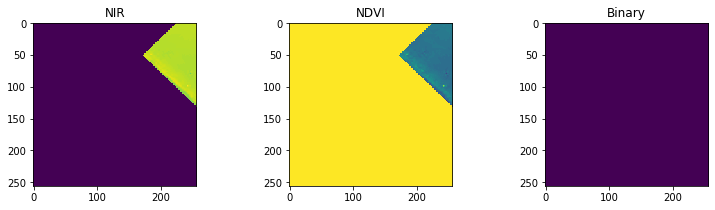

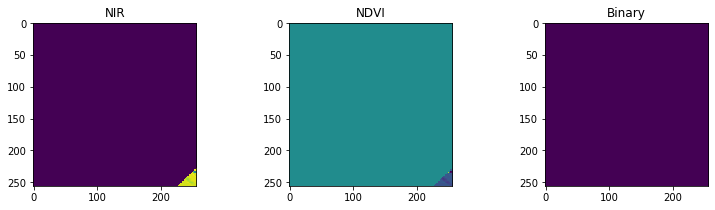

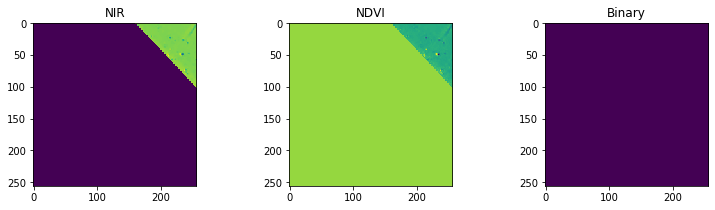

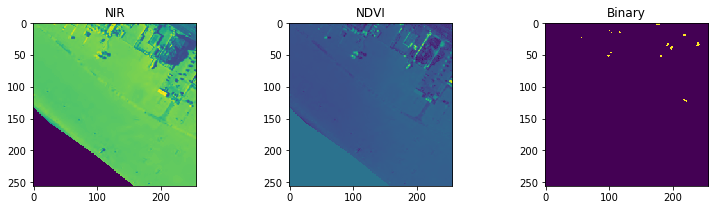

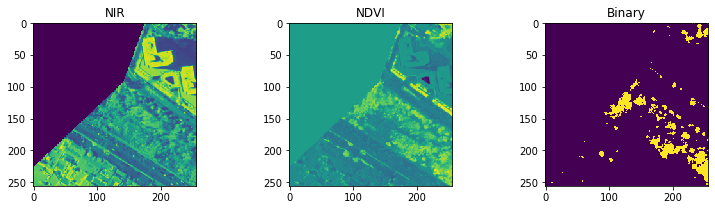

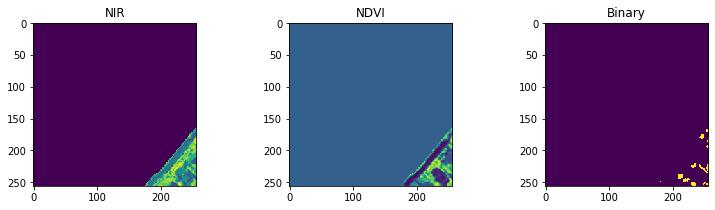

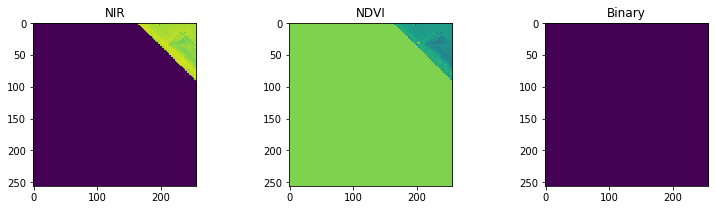

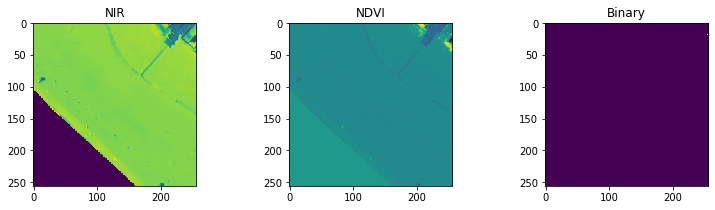

In [13]:
for i in range(DEFAULT_BATCH_SIZE):    
    fig, axs=plt.subplots(1,3,figsize=(13,3))
    axs[0].imshow(train_loader_sample['input'][i][3])   
    axs[0].set_title('NIR')
    axs[1].imshow(train_loader_sample['input'][i][4])
    axs[1].set_title('NDVI')
    axs[2].imshow(train_loader_sample['target'][i])
    axs[2].set_title('Binary')
    plt.show()